# import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as td
import torchvision as tv
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Load dataset

In [2]:
Dataset = './SDOBenchmark-data-full/'
class SDODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(SDODataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.df = pd.read_csv(root_dir + mode + '/meta_data.csv', sep=",", parse_dates=["start", "end"], index_col="id")
        self.image_path = []
        self.label = []
        self.id = []
        for row in self.df.iterrows():
            ar_nr, p = row[0].split("_", 1)
            img_path = os.path.join(root_dir, mode, ar_nr, p)
            for img_name in os.listdir(img_path):
                if img_name.endswith('_magnetogram.jpg'):
                    self.image_path.append(os.path.join(img_path, img_name))
                    self.label.append(row[1]['peak_flux'])
                    self.id.append(row[0])
    def __len__(self):
        return len(self.label)
    def __repr__(self):
        return "SDODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        img = Image.open(img_path)
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            ])
        x = transform(img)
        d = self.label[idx]
        return x, np.log(d)

# Train the auto encoder

In [3]:
# !python train_autoencoder.py #train for 5 epochs.

# Show a train sample from dataset and plot the output of auto encoder


checkpoint: autoencoder/BEST_checkpoint.tar


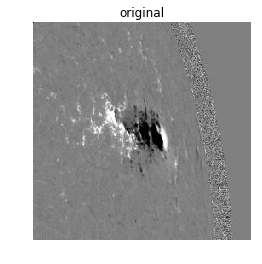

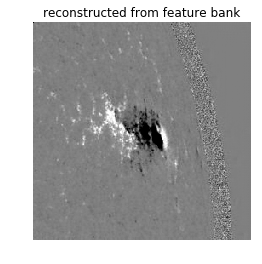

In [4]:
def myimshow(image, ax=plt, title = ''):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    image[0,0,0] = 0
    h = ax.imshow(image[:,:,0], cmap = 'gray')
    ax.axis('off')
    ax.title(title)
    return h
train_set = SDODataset(Dataset, mode = 'training')
test_set = SDODataset(Dataset, mode = 'test')
x,d = train_set.__getitem__(1)

# show orginal plot
myimshow(x, title='original')

# show plot reconstructed from auto encoder
x = x.view(1,1,256,256).to(device)
from config import autoencoder_checkpoint
checkpoint = '{}/BEST_checkpoint.tar'.format(autoencoder_checkpoint)  # model checkpoint
print('checkpoint: ' + str(checkpoint))
checkpoint = torch.load(checkpoint, map_location=device)
model = checkpoint['model']
del checkpoint

model = model.to(device)
model.eval()
with torch.no_grad():
    preds = model(x)
plt.figure()
myimshow(preds[0], title = 'reconstructed from feature bank')

# Plot train loss and validation loss

For this part, you need to train 5 epochs about 2 hour to get all checkpoint(about 300MB*5). If you do not want do so, please refer our report. We have trained 5 epochs and ploted this part.

Text(0, 0.5, 'Loss')

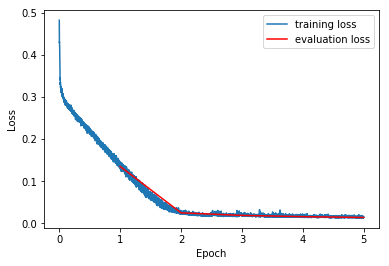

In [5]:
data_path = 'autoencoder_loss.npz'
load_from_saved_file = True
if load_from_saved_file == False:
# load from checkpoint , training checkpoints needed
    train_loss = [None]*5
    val_loss = [None]*5
    for file_name in os.listdir(autoencoder_checkpoint):
        split = file_name.split('_')
        if split[1].isdigit():
            checkpoint = '{}/'.format(autoencoder_checkpoint)+file_name
            print('checkpoint: ' + str(checkpoint))
            checkpoint = torch.load(checkpoint, map_location=device)
            train_loss[int(split[1])] = checkpoint['train_loss']
            val_loss[int(split[1])] = float(split[2][:5])
            del checkpoint
    all_train_loss = []
    for i in train_loss:
        all_train_loss.extend(i)
    np.savez(data_path, all_train_loss = np.array(all_train_loss), val_loss = np.array(val_loss))
else:
# load from saved file
    npzfile = np.load(data_path)
    all_train_loss = npzfile['all_train_loss']
    val_loss = npzfile['val_loss']
plt.plot(np.linspace(0,5,len(all_train_loss)),all_train_loss,label="training loss")
plt.plot(range(1,6),val_loss,color = 'r',label="evaluation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Build a regression network with pre-trained auto-encoder and train it

In [6]:
# !python train_regression.py #train for 5 epochs.

# Plot the confusion matrix of 5 classes

For this part, you need to train 5 epochs about 2 hour to get all checkpoint(about 1.67GB*5). If you do not want do so, please refer our report. We have trained 5 epochs and ploted this part.

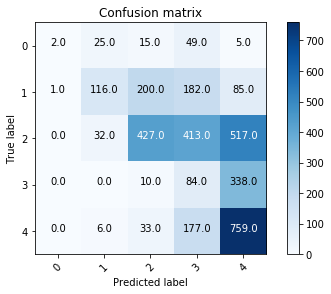

In [7]:
from utils import plot_confusion_matrix
data_path = 'confusion_matrix.npz'
load_from_saved_file = True
if load_from_saved_file == False:
    from config import regression_checkpoint
    from utils import plot_confusion_matrix
    checkpoint = '{}/BEST_checkpoint.tar'.format(regression_checkpoint)  # model checkpoint
    print('checkpoint: ' + str(checkpoint))
    checkpoint = torch.load(checkpoint, map_location=device)
    model = checkpoint['model']
    del checkpoint
    model = model.to(device)

    confusion = np.zeros([5,5])
    correct = 0
    for i in range(test_set.__len__()):
        x,d = test_set.__getitem__(i)
        x = x.view(1,1,256,256).cuda()
        with torch.no_grad():
            d_hat = model(x)
        d = np.exp(d)
        d_hat = np.exp(d_hat[0].cpu().numpy())[0]
        if d > 1e-4:
            tmp1 = 0
        elif d > 1e-5:
            tmp1 = 1
        elif d > 1e-6:
            tmp1 = 2
        elif d > 1e-7:
            tmp1 = 3
        else:
            tmp1 = 4
        if d_hat > 1e-4:
            tmp2 = 0
        elif d_hat > 1e-5:
            tmp2 = 1
        elif d_hat > 1e-6:
            tmp2 = 2
        elif d_hat > 1e-7:
            tmp2 = 3
        else:
            tmp2 = 4
        if np.absolute(tmp1 - tmp2) <= 1:
            correct += 1
        confusion[tmp1,tmp2] +=1
    np.savez(data_path, confusion = np.array(confusion), correct = correct)
else:
# load from saved file
    npzfile = np.load(data_path)
    confusion = npzfile['confusion']
    correct = npzfile['correct']
plot_confusion_matrix(confusion, classes = range(5))

In [8]:
print('correct:', correct,"  total: " ,test_set.__len__(), ' accuracy: ',correct/ test_set.__len__())

correct: 2584   total:  3476  accuracy:  0.7433831990794016


# Plot train loss and validation loss

Text(0, 0.5, 'Loss')

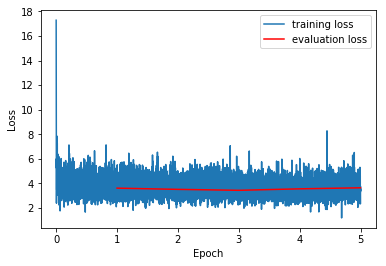

In [9]:
data_path = 'regression_loss.npz'
load_from_saved_file = True
epoch = 5
if load_from_saved_file == False:
# load from checkpoint , training checkpoints needed
    
    train_loss = [None]*epoch
    val_loss = [None]*epoch
    for file_name in os.listdir(regression_checkpoint):
        split = file_name.split('_')
        if split[1].isdigit():
            checkpoint = '{}/'.format(regression_checkpoint)+file_name
            print('checkpoint: ' + str(checkpoint))
            checkpoint = torch.load(checkpoint, map_location=device)
            train_loss[int(split[1])] = checkpoint['train_loss']
            val_loss[int(split[1])] = float(split[2][:5])
            del checkpoint

    all_train_loss = []
    for i in train_loss:
        all_train_loss.extend(i)
    np.savez(data_path, all_train_loss = np.array(all_train_loss), val_loss = np.array(val_loss))
else:
# load from saved file
    npzfile = np.load(data_path)
    all_train_loss = npzfile['all_train_loss']
    val_loss = npzfile['val_loss']
plt.plot(np.linspace(0,epoch,len(all_train_loss)),all_train_loss,label="training loss")
plt.plot(range(1,epoch + 1),val_loss,color = 'r',label="evaluation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")